<a href="https://colab.research.google.com/github/jamg-upv/0Reto21d_ago24_LLMclassification/blob/main/py/Reto21d_ago24_LLMhiwp_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preparacion previa (ejecutar solo una vez)


CONECTARME al ENTORNO DE PRODUCCION TPU 256 GB RAM (o me chupare la ram en nada) este es my rapido pero me consume todo mi enteorno de ejecucion en nada.
PUEDO PROBAR CON GPU que me da 12 +15 GB de ram

Consejos para Ahorrar RAM y GPU en Google Colab
Usar torch.no_grad(): Envuelve tus predicciones en with torch.no_grad() para evitar guardar los cálculos de gradientes, lo que ahorra una cantidad significativa de memoria.
Liberar memoria: Asegúrate de liberar la memoria de la GPU cuando ya no necesites los datos allí. Puedes hacer esto con torch.cuda.empty_cache().
Procesamiento por lotes: Si aún enfrentas problemas de memoria, considera procesar tus datos en lotes más pequeños en lugar de cargar todo en la memoria a la vez.

Paso 1: Habilitar la GPU en Google Colab
Primero, asegúrate de que la sesión de Colab esté configurada para usar la GPU:

Ve a Entorno de ejecución en la barra de menús.
Selecciona Cambiar tipo de entorno de ejecución.
En el menú desplegable de Acelerador de hardware, elige GPU.
Haz clic en Guardar para aplicar los cambios.
Paso 2: Modificar el Código para Utilizar la GPU
Asegúrate de que tu código esté configurado para enviar los cálculos a la GPU. Aquí te muestro cómo modificar tu código de Transformers para usar la GPU:

In [1]:
#conectar con repositorio github publico para acceso a los datasets
!git clone https://github.com/jamg-upv/0Reto21d_ago24_LLMclassification.git

fatal: destination path '0Reto21d_ago24_LLMclassification' already exists and is not an empty directory.


In [2]:
#conecar a google drive para guardar alli los outputs que quiera mantener (y que no se me olvide descargarlos) luego los subiré a Git para su uso posterior
from google.colab import drive
import os

# Montar Google Drive si aún no está montado
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

In [3]:
# Define el nombre del archivo y el path de salida
file_name = 'hiwp_data_processed.csv'
output_path = '/content/drive/MyDrive/Reto21dias_24'

# Construye el path completo
full_path = os.path.join(output_path, file_name)

# Define la variable con el nombre de la columna
target_column = 'processed_text'

In [4]:
# # Instalar las dependencias necesarias
# !pip install transformers
# !pip install sentence-transformers
# !pip install scikit-learn
import pkg_resources
import subprocess

required_packages = [
    'transformers',
    'torch',
    'pandas',
    'numpy',
    'scikit-learn'
]

installed_packages = {pkg.key for pkg in pkg_resources.working_set}

for package in required_packages:
    if package in installed_packages:
        print(f"{package} ya está instalado.")
    else:
        print(f"{package} no está instalado. Instalando...")
        subprocess.check_call(["pip", "install", package])
        print(f"{package} ha sido instalado.")

print("\nTodas las bibliotecas necesarias están ahora instaladas.")

from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Leer el archivo CSV (es un CSV de Open Office si lo genero con MSexcel no se mapea bien sin dar atributos adicionales)
hiwp_data = pd.read_csv(full_path)

# Seleccionar las filas de la 1 a la 12 (índices 0 a 11) que tienen las definiciones de componentes de HIWP. Comentar si quiero trabajar con filas adicionales
# limito explicitamente a las dos primeras columnas que son los datos con los que quiero trabajar (la tercera tiene comentarios de clasificacion de las filas articulos)
hiwp_data = hiwp_data.iloc[0:12, :]

# Mostrar el DataFrame resultante
print(hiwp_data)

# codigo original que funciona si la entrada no supera los 512 tokens
# # Cargar el modelo y el tokenizador
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# model = AutoModel.from_pretrained("bert-base-uncased")

# # Tokenizar las descripciones de HIWP
# tokenized_texts = [tokenizer.encode_plus(text, return_tensors="pt", padding=True) for text in hiwp_data[target_column].tolist()]

# # Generar embeddings con output_hidden_states=True
# hiwp_component_embeddings = [model(**encoded_text, output_hidden_states=True).hidden_states for encoded_text in tokenized_texts]

# este modelo funciona pero chupa mucha ram y google colaba me expulsa del entorno de ejecuación
# # Cargar el modelo y el tokenizador de Longformer
# tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-base-4096")
# model = AutoModel.from_pretrained("allenai/longformer-base-4096")

# # Asumiendo que 'hiwp_data' es tu DataFrame y 'target_column' es la columna que contiene el texto
# texts = hiwp_data[target_column].tolist()

# # Tokenizar las descripciones de HIWP
# tokenized_texts = [tokenizer(text, max_length=1024, truncation=True, return_tensors="pt", padding=True) for text in texts]

# # Generar embeddings con output_hidden_states=True
# hiwp_component_embeddings = [model(**encoded_text, output_hidden_states=True).hidden_states for encoded_text in tokenized_texts]


# Configurar el dispositivo en función de la disponibilidad de CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar el modelo y el tokenizador de Longformer
tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-base-4096")
model = AutoModel.from_pretrained("allenai/longformer-base-4096")

# Mover el modelo a la GPU
model.to(device)

# Asumiendo que 'hiwp_data' y 'target_column' están definidos
texts = hiwp_data[target_column].tolist()

# Tokenizar las descripciones
tokenized_texts = [tokenizer(text, max_length=4096, truncation=True, return_tensors="pt", padding=True) for text in texts]

# Generar embeddings con output_hidden_states=True
hiwp_component_embeddings = []
for encoded_text in tokenized_texts:
    # Mover el tensor tokenizado a la GPU
    encoded_text = {k: v.to(device) for k, v in encoded_text.items()}

    # Procesar en la GPU y obtener los estados ocultos
    with torch.no_grad():  # Esto asegura que no se calculen gradientes (ahorra memoria)
        outputs = model(**encoded_text, output_hidden_states=True)
        hiwp_component_embeddings.append(outputs.hidden_states)


transformers ya está instalado.
torch ya está instalado.
pandas ya está instalado.
numpy ya está instalado.
scikit-learn ya está instalado.

Todas las bibliotecas necesarias están ahora instaladas.
             Component                                        Description  \
0   Select&Recruitment  Rigorous Selection and Recruitment Selecting t...   
1             Training  Continuous Training and Development Investing ...   
2          Empowerment  Employee participation Autonomy and Empowermen...   
3          PerformEval  Performance Evaluation and Feedback Providing ...   
4        Compensations  Competitive Compensation and Benefits Offering...   
5              FairJob  Fair Work Practices Treating employees fairly ...   
6        Communication  Open and Transparent Communication Sharing inf...   
7               Career  Career and Succession Planning Helping employe...   
8        LeaderDevelop  Leadership Development A conscious effort to d...   
9      WorkLifeBalance  Work-Lif

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Input ids are automatically padded to be a multiple of `config.attention_window`: 512


In [5]:

# 1. Ver los embeddings generados
print("Embeddings generados:")
for i, embeddings in enumerate(hiwp_component_embeddings):
    print(f"Componente {hiwp_data['Component'].iloc[i]}:")
    print(embeddings[-1])  # Embeddings de la última capa
    print()


Embeddings generados:
Componente Select&Recruitment:
tensor([[[-9.3906e-02,  8.3954e-03,  8.8578e-03,  ..., -2.6486e-01,
          -3.4569e-02, -1.9692e-02],
         [ 2.9832e-02, -1.1119e-01,  6.7319e-02,  ...,  1.9723e-02,
           1.9594e-02,  3.4271e-01],
         [ 4.7238e-03,  1.2220e-01,  5.5063e-02,  ...,  2.6522e-01,
          -4.7205e-02,  1.9699e-01],
         ...,
         [-2.2265e-01, -3.4780e-01, -1.0794e-01,  ..., -9.5034e-01,
          -1.0589e-01, -2.0062e-01],
         [-1.6915e-01, -1.3524e-01,  5.0965e-04,  ..., -5.2618e-01,
           2.6111e-01,  2.2819e-01],
         [-1.1392e-01, -6.2387e-02, -5.3719e-02,  ..., -3.4794e-01,
           1.8852e-02, -2.8657e-02]]], device='cuda:0')

Componente Training:
tensor([[[-0.0882, -0.0067,  0.0233,  ..., -0.3385, -0.0303, -0.0358],
         [ 0.1702, -0.0318,  0.0132,  ..., -0.3910,  0.2134,  0.2207],
         [ 0.1141, -0.0848,  0.0490,  ..., -0.4117,  0.1073,  0.1575],
         ...,
         [ 0.1014, -0.3268,  0.1034

In [6]:
n_clusters = 5  # Puedes ajustar este número según tus necesidades


##este cdigo funciona para extraer embeedings pero no consigo reutilizarlos despues

In [ ]:
# Cargar el modelo IAgen
model = pipeline('feature-extraction', model='bert-base-uncased')

# Generar representaciones vectoriales de las componentes de HIWP
hiwp_component_embeddings = [model(component)[0] for component in hiwp_data["Description"].tolist()]

# Imprimir el tipo del primer elemento de la primera sublista
print(type(hiwp_component_embeddings[0][0]))

# Si el elemento es un tensor de PyTorch, imprimir su forma
if isinstance(hiwp_component_embeddings[0][0], torch.Tensor):
    print(hiwp_component_embeddings[0][0].shape)

    print(model(hiwp_data["Description"][0]))

[[[-0.3533148467540741, -0.21513661742210388, -0.47016096115112305, -0.02450808696448803, 0.517326295375824, -0.38760846853256226, 0.017082933336496353, 0.5354235172271729, -0.027287933975458145, -0.9179192781448364, -0.10439053922891617, 0.14401423931121826, 0.13754397630691528, 0.20004616677761078, -0.24756985902786255, 0.003025476122274995, 0.24697193503379822, 0.7981260418891907, 0.17722423374652863, -0.5300544500350952, -0.6994251608848572, -0.6386146545410156, -0.034964513033628464, 0.46650704741477966, -0.1518421620130539, -0.09932739287614822, 0.09184559434652328, -0.17062243819236755, -0.05119341239333153, -0.27797651290893555, -0.35425645112991333, -0.6134098768234253, -0.13744737207889557, -0.685953676700592, 0.1872338354587555, 0.11063522100448608, -0.25164249539375305, 0.25731736421585083, -0.08128700405359268, 0.03757414594292641, -0.7738260626792908, 1.0036715269088745, 0.675430417060852, -0.015041404403746128, 0.017550557851791382, 0.21194790303707123, -4.57754039764404

# Un enfoque propuesto ChatGPT4o
Quiero un codigo python para correr en google collab  que 1) me permita ver los embeddings generados; 2) me agrupe los components por proximidad de embeddings; 3) una tabla de distancia de cosenos entre todos los componentes. Si es posible quiero que los embeedigns se extraigan con un modelo pre-entrenado (por ejmplo BERT o el que sea mas adecuado apra esta tareas) mis datos están en # Leer el archivo CSV
hiwp_data = pd.read_csv("hiwp_components.csv") que es un csv con dos columnas: Component,Description


In [7]:
# # Instalar las dependencias necesarias
# !pip install transformers
# !pip install sentence-transformers
# !pip install scikit-learn
import pkg_resources
import subprocess

required_packages = [
    'pandas',
    'numpy',
    'scikit-learn',
    'matplotlib',
    'sentence-transformers',
    'umap-learn',
    'transformers',
    'seaborn'
]

installed_packages = {pkg.key for pkg in pkg_resources.working_set}

for package in required_packages:
    if package in installed_packages:
        print(f"{package} ya está instalado.")
    else:
        print(f"{package} no está instalado. Instalando...")
        subprocess.check_call(["pip", "install", package])
        print(f"{package} ha sido instalado.")

print("\nTodas las bibliotecas necesarias están ahora instaladas.")

# Importar las bibliotecas necesarias
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans

# Cargar el modelo preentrenado de BERT
model = SentenceTransformer('bert-base-nli-mean-tokens')

# Obtener las descripciones
descriptions = hiwp_data[target_column].tolist()

# Generar los embeddings para cada descripción
embeddings = model.encode(descriptions)

# Calcular la matriz de similitud de coseno
cosine_sim_matrix = cosine_similarity(embeddings)

# Crear un DataFrame con las distancias de coseno
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=hiwp_data['Component'], columns=hiwp_data['Component'])

# Mostrar la tabla de distancia de cosenos
print("Tabla de distancia de cosenos:")
print(cosine_sim_df)


# 2. Agrupar los componentes por proximidad de embeddings
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

hiwp_data['Cluster'] = cluster_labels

print("Componentes agrupados por cluster:")
for cluster in range(n_clusters):
    print(f"\nCluster {cluster}:")
    print(hiwp_data[hiwp_data['Cluster'] == cluster]['Component'].tolist())




pandas ya está instalado.
numpy ya está instalado.
scikit-learn ya está instalado.
matplotlib ya está instalado.
sentence-transformers no está instalado. Instalando...
sentence-transformers ha sido instalado.
umap-learn no está instalado. Instalando...
umap-learn ha sido instalado.
transformers ya está instalado.
seaborn ya está instalado.

Todas las bibliotecas necesarias están ahora instaladas.


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Tabla de distancia de cosenos:
Component           Select&Recruitment  Training  Empowerment  PerformEval  \
Component                                                                    
Select&Recruitment            1.000000  0.785736     0.731736     0.647969   
Training                      0.785736  1.000000     0.815084     0.735057   
Empowerment                   0.731736  0.815084     1.000000     0.806770   
PerformEval                   0.647969  0.735057     0.806770     1.000000   
Compensations                 0.728025  0.755133     0.788496     0.651718   
FairJob                       0.633240  0.669097     0.754394     0.739226   
Communication                 0.695030  0.789706     0.861808     0.786418   
Career                        0.677372  0.772228     0.874582     0.839626   
LeaderDevelop                 0.666010  0.770785     0.825035     0.739287   
WorkLifeBalance               0.638031  0.773799     0.807327     0.819157   
Recognition                   0.5

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


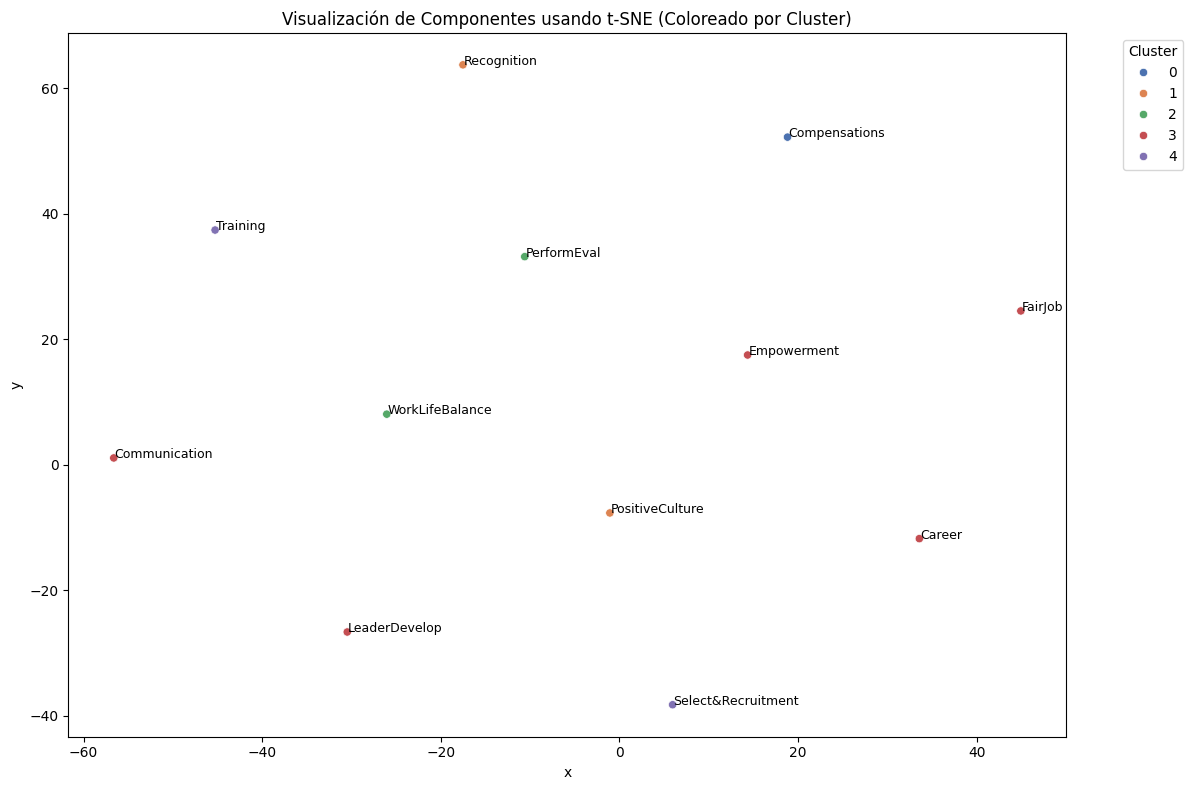

In [8]:
# Ajustar la perplexity en función del número de muestras
n_samples = len(embeddings)
perplexity = min(30, n_samples - 1)

# Reducir las dimensiones de los embeddings para visualización usando t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity)
embeddings_2d = tsne.fit_transform(embeddings)

# Crear un DataFrame con los componentes, sus coordenadas 2D y el cluster
tsne_df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
tsne_df['Component'] = hiwp_data['Component']
tsne_df['Cluster'] = hiwp_data['Cluster']

# Visualizar los componentes en un gráfico 2D con colores por cluster
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x='x', y='y', hue='Cluster', palette='deep', data=tsne_df)

# Añadir etiquetas para cada punto
for i, row in tsne_df.iterrows():
    plt.text(row['x']+0.1, row['y'], row['Component'], fontsize=9)

plt.title('Visualización de Componentes usando t-SNE (Coloreado por Cluster)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

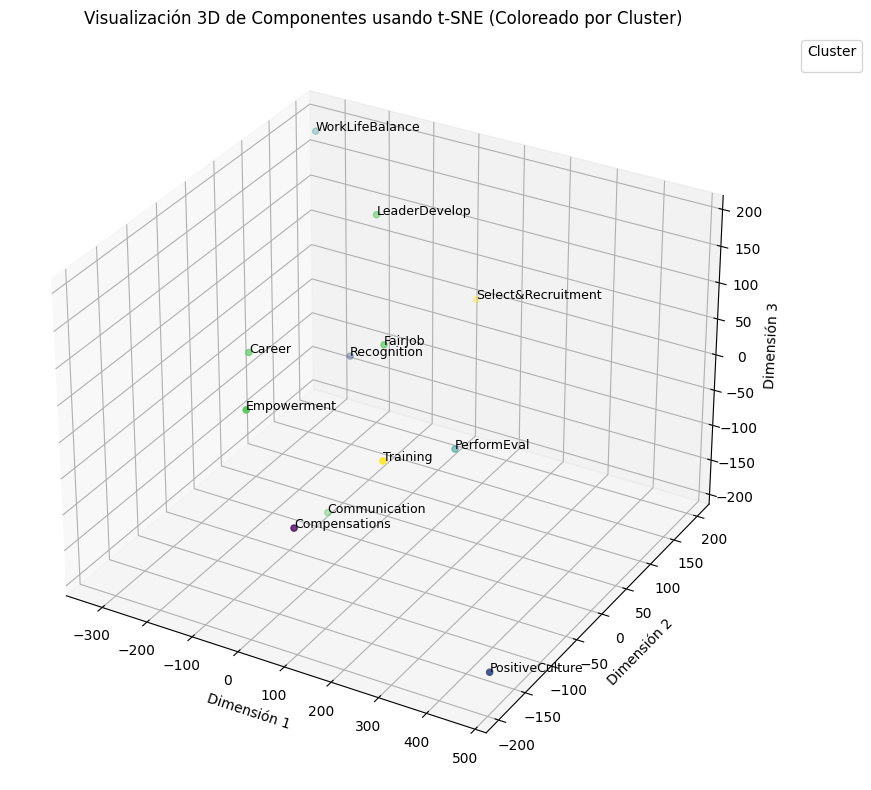

In [9]:
# Definir el número de dimensiones deseadas (1, 2 o 3)
n_dimensions = 3  # Cambia esto a 1, 2 o 3 según lo que desees

# Asegurarse de que n_dimensions sea válido
if n_dimensions not in [1, 2, 3]:
    raise ValueError("n_dimensions debe ser 1, 2 o 3")
# Ajustar la perplexity en función del número de muestras
n_samples = len(embeddings)
perplexity = min(30, n_samples - 1)

# Reducir las dimensiones de los embeddings para visualización usando t-SNE
tsne = TSNE(n_components=n_dimensions, random_state=0, perplexity=perplexity)
embeddings_nd = tsne.fit_transform(embeddings)

# Crear un DataFrame con los componentes y sus coordenadas
tsne_df = pd.DataFrame(embeddings_nd, columns=[f'dim{i+1}' for i in range(n_dimensions)])
tsne_df['Component'] = hiwp_data['Component']
tsne_df['Cluster'] = hiwp_data['Cluster']

# Visualizar los componentes
plt.figure(figsize=(12, 8))

if n_dimensions == 1:
    sns.scatterplot(x='dim1', y=[0]*len(tsne_df), hue='Cluster', palette='deep', data=tsne_df)
    for i, row in tsne_df.iterrows():
        plt.text(row['dim1'], 0, row['Component'], fontsize=9)
    plt.title('Visualización 1D de Componentes usando t-SNE (Coloreado por Cluster)')
    plt.ylabel('')  # Eliminar etiqueta del eje Y

elif n_dimensions == 2:
    scatter = sns.scatterplot(x='dim1', y='dim2', hue='Cluster', palette='deep', data=tsne_df)
    for i, row in tsne_df.iterrows():
        plt.text(row['dim1']+0.1, row['dim2'], row['Component'], fontsize=9)
    plt.title('Visualización 2D de Componentes usando t-SNE (Coloreado por Cluster)')

else:  # n_dimensions == 3
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(tsne_df['dim1'], tsne_df['dim2'], tsne_df['dim3'],
                         c=tsne_df['Cluster'], cmap='viridis')
    for i, row in tsne_df.iterrows():
        ax.text(row['dim1'], row['dim2'], row['dim3'], row['Component'], fontsize=9)
    ax.set_title('Visualización 3D de Componentes usando t-SNE (Coloreado por Cluster)')
    ax.set_xlabel('Dimensión 1')
    ax.set_ylabel('Dimensión 2')
    ax.set_zlabel('Dimensión 3')

plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Otro enfoque desde cero con Claude 3.5-sonnet
Quiero un codigo python para correr en google collab que 1) me permita ver los embeddings generados; 2) me agrupe los components por proximidad de embeddings; 3) una tabla de distancia de cosenos entre todos los componentes. Si es posible quiero que los embeedigns se extraigan con un modelo pre-entrenado (por ejmplo BERT o el que sea mas adecuado apra esta tareas) mis datos están en # Leer el archivo CSV
hiwp_data = pd.read_csv("hiwp_components.csv") que es un csv con dos columnas: Component,Description




In [10]:
import pkg_resources
import subprocess

required_packages = [
    'pandas',
    'numpy',
    'scikit-learn',
    'matplotlib',
    # 'sentence-transformers',
    'umap-learn'
]

installed_packages = {pkg.key for pkg in pkg_resources.working_set}

for package in required_packages:
    if package in installed_packages:
        print(f"{package} ya está instalado.")
    else:
        print(f"{package} no está instalado. Instalando...")
        subprocess.check_call(["pip", "install", package])
        print(f"{package} ha sido instalado.")

print("\nTodas las bibliotecas necesarias están ahora instaladas.")

pandas ya está instalado.
numpy ya está instalado.
scikit-learn ya está instalado.
matplotlib ya está instalado.
umap-learn no está instalado. Instalando...
umap-learn ha sido instalado.

Todas las bibliotecas necesarias están ahora instaladas.


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.02k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


Componentes agrupados por cluster:

Cluster 0:
['Training', 'Empowerment', 'PerformEval', 'Communication', 'Career', 'LeaderDevelop', 'WorkLifeBalance']

Cluster 1:
['Compensations']

Cluster 2:
['FairJob']

Cluster 3:
['Select&Recruitment']

Cluster 4:
['Recognition', 'PositiveCulture']


<ipython-input-11-cf252c7d4625>:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', n_clusters)


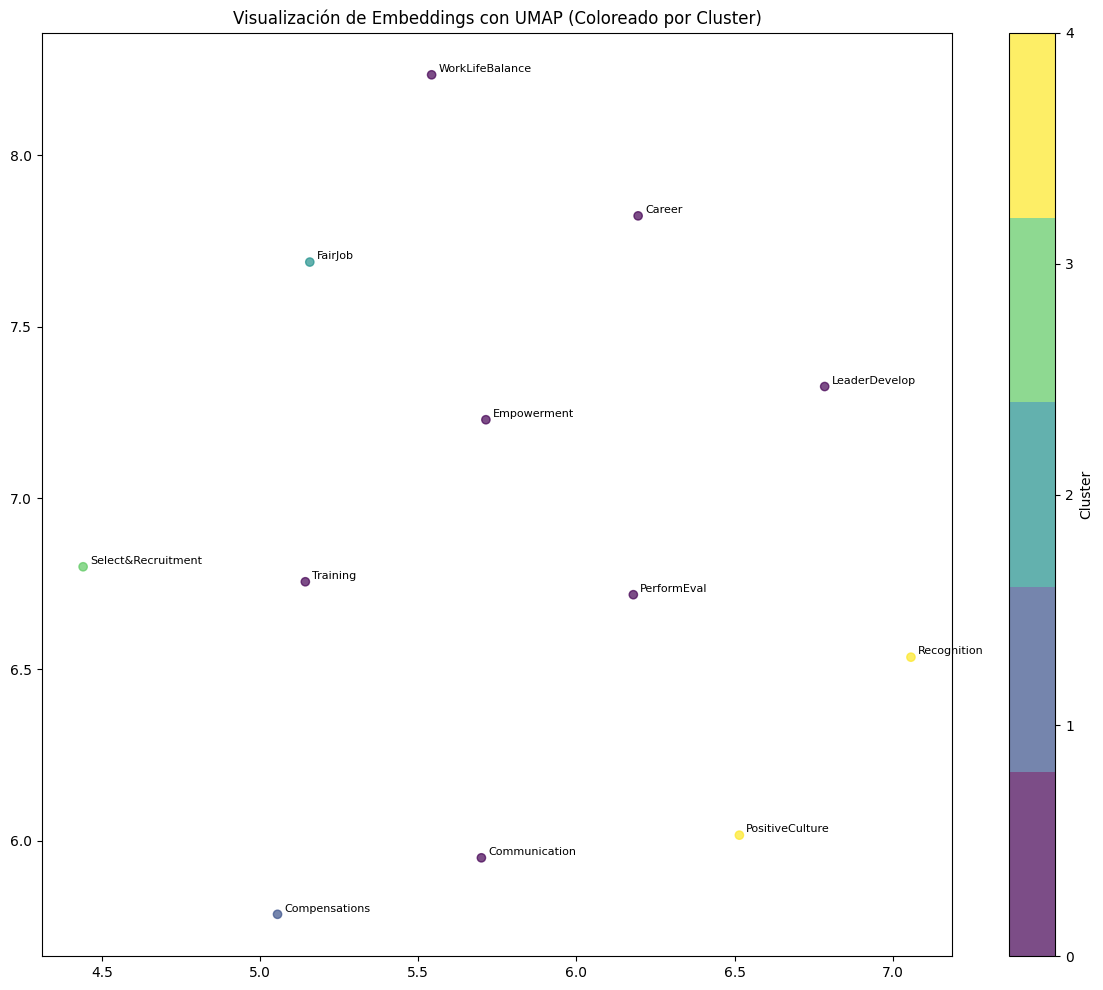


Tabla de distancia de cosenos entre componentes:
Component           Select&Recruitment  Training  Empowerment  PerformEval  \
Component                                                                    
Select&Recruitment            1.000000  0.808288     0.727984     0.665438   
Training                      0.808288  1.000000     0.811540     0.709450   
Empowerment                   0.727984  0.811540     1.000000     0.789432   
PerformEval                   0.665438  0.709450     0.789432     1.000000   
Compensations                 0.725181  0.775151     0.762788     0.682237   
FairJob                       0.623006  0.675206     0.675180     0.704251   
Communication                 0.715197  0.791476     0.830554     0.785174   
Career                        0.769492  0.803284     0.848116     0.805878   
LeaderDevelop                 0.680706  0.770396     0.826119     0.725183   
WorkLifeBalance               0.679185  0.798774     0.857712     0.791061   
Recognition   

In [11]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from umap import UMAP



# Cargar el modelo pre-entrenado de BERT
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

# Generar embeddings
embeddings = model.encode(hiwp_data[target_column].tolist())



# 1 Agrupar los componentes por proximidad de embeddings
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

hiwp_data['Cluster'] = cluster_labels

print("Componentes agrupados por cluster:")
for cluster in range(n_clusters):
    print(f"\nCluster {cluster}:")
    print(hiwp_data[hiwp_data['Cluster'] == cluster]['Component'].tolist())

# 2. Visualizar los embeddings generados con UMAP
umap = UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42)
umap_embeddings = umap.fit_transform(embeddings)

# 3. Crear el gráfico
plt.figure(figsize=(12, 10))

# Usar un mapa de colores para los clusters
cmap = plt.cm.get_cmap('viridis', n_clusters)

# Graficar los puntos coloreados por cluster
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1],
                      c=cluster_labels, cmap=cmap, alpha=0.7)

# Añadir etiquetas para cada punto
for i, txt in enumerate(hiwp_data['Component']):
    plt.annotate(txt, (umap_embeddings[i, 0], umap_embeddings[i, 1]),
                 xytext=(5, 2), textcoords='offset points', fontsize=8)

# Configurar el título y la leyenda
plt.title('Visualización de Embeddings con UMAP (Coloreado por Cluster)')
plt.colorbar(scatter, label='Cluster', ticks=range(n_clusters))

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()

# 3. Crear una tabla de distancia de cosenos entre todos los componentes
cosine_sim = cosine_similarity(embeddings)
cosine_df = pd.DataFrame(cosine_sim, columns=hiwp_data['Component'], index=hiwp_data['Component'])

print("\nTabla de distancia de cosenos entre componentes:")
print(cosine_df)

# Guardar la tabla de distancia de cosenos en un archivo CSV
cosine_df.to_csv("cosine_distance_table.csv")
print("\nLa tabla de distancia de cosenos se ha guardado en 'cosine_distance_table.csv'")

#Este es con word2vec no con bert

Retocar código python para gogle colab. Este código funciona pero queiro que muestre las distancias en formato decimal (sin elevar a potencias) y que me represente los clusters de componentes """from sklearn.feature_

Tabla de distancias de coseno:
Component           Select&Recruitment  Training  Empowerment  PerformEval  \
Component                                                                    
Select&Recruitment              0.0000    0.9925       0.9810       0.9874   
Training                        0.9925    0.0000       0.9416       0.9946   
Empowerment                     0.9810    0.9416      -0.0000       0.9897   
PerformEval                     0.9874    0.9946       0.9897       0.0000   
Compensations                   0.9847    0.9681       0.9658       0.9741   
FairJob                         1.0000    0.9810       0.9805       0.9940   
Communication                   0.9980    0.9788       0.9586       0.9454   
Career                          1.0000    0.9703       0.9754       0.9924   
LeaderDevelop                   0.9890    0.9298       0.9836       0.9958   
WorkLifeBalance                 1.0000    0.9499       0.9741       0.9933   
Recognition                     0

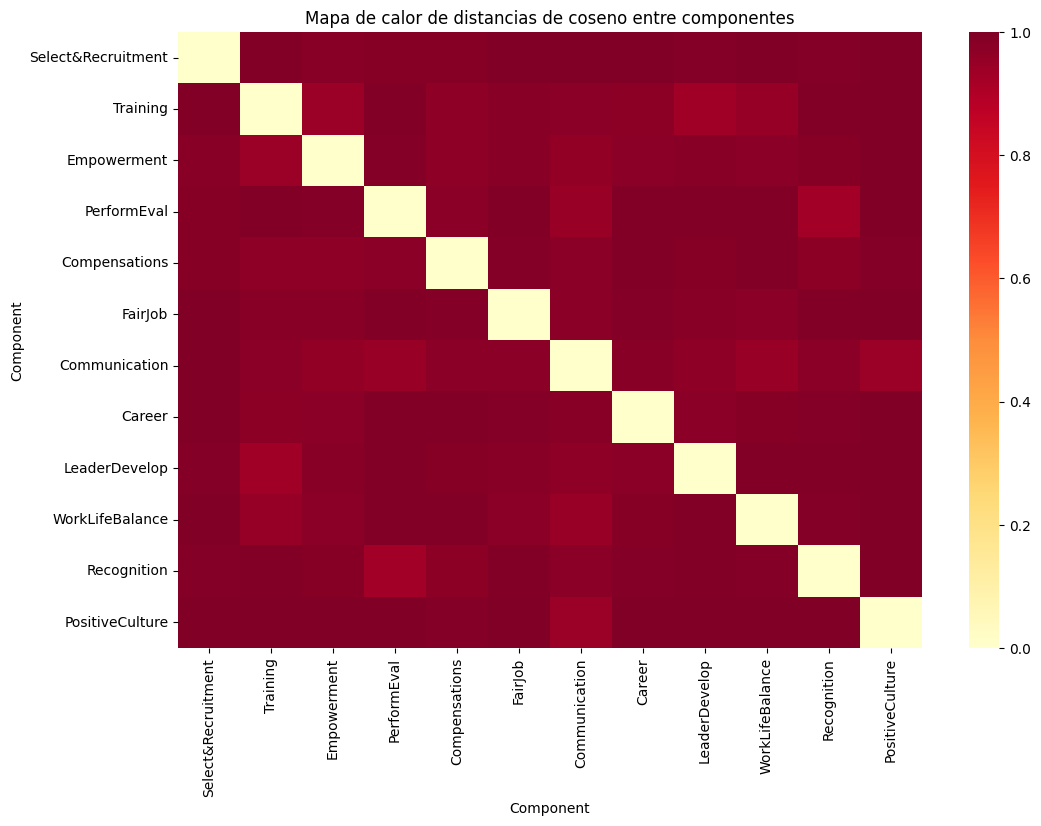

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


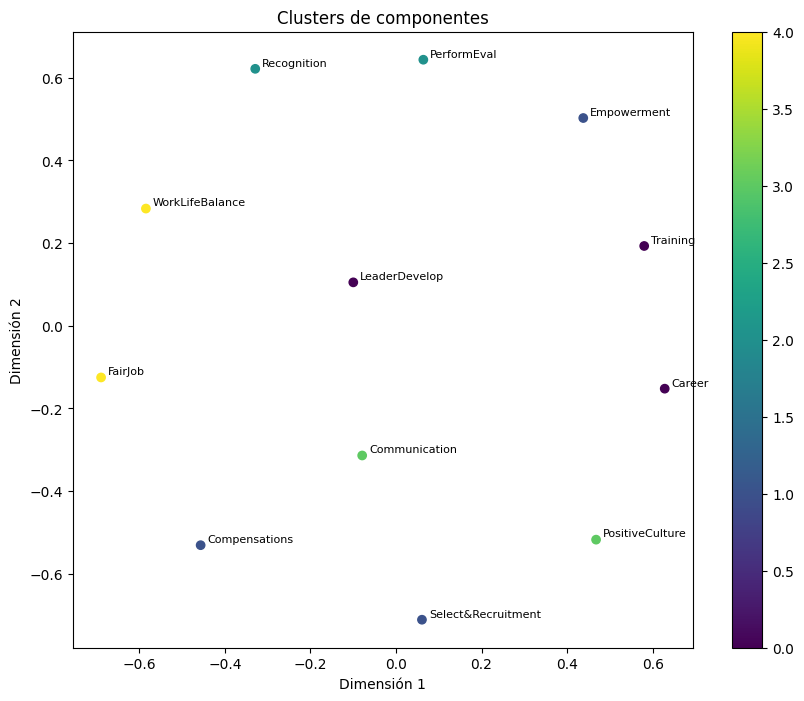

In [12]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns

# Asumiendo que ya tienes hiwp_data cargado
# Si no, deberías cargarlo aquí

# Crear el vectorizador TF-IDF
vectorizer = TfidfVectorizer()

# Ajustar y transformar las descripciones de componentes
component_descriptions = hiwp_data[target_column].tolist()
tfidf_matrix = vectorizer.fit_transform(component_descriptions)

# Crear una matriz de distancias de coseno
cosine_distances = 1 - cosine_similarity(tfidf_matrix)
distance_df = pd.DataFrame(cosine_distances, columns=hiwp_data["Component"], index=hiwp_data["Component"])
print("Tabla de distancias de coseno:")
print(distance_df.round(4))  # Redondear a 4 decimales para mejor visualización

# Agrupar los componentes por proximidad de embeddings
clustering = AgglomerativeClustering(n_clusters=n_clusters, distance_threshold=None).fit(tfidf_matrix.toarray())
cluster_labels = clustering.labels_

# Crear un DataFrame con los componentes y sus clústeres
component_clusters = pd.DataFrame({
    "Component": hiwp_data["Component"],
    "Cluster": cluster_labels
})
print("\nComponentes agrupados por clústeres:")
print(component_clusters.groupby("Cluster")["Component"].apply(list))

# Visualizar los clusters
plt.figure(figsize=(12, 8))
sns.heatmap(distance_df, cmap='YlOrRd')
plt.title('Mapa de calor de distancias de coseno entre componentes')
plt.show()

# Visualizar los clusters en un gráfico de dispersión 2D
from sklearn.manifold import MDS

# Reducir la dimensionalidad a 2D
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pos = mds.fit_transform(cosine_distances)

# Crear un gráfico de dispersión
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pos[:, 0], pos[:, 1], c=cluster_labels, cmap='viridis')
plt.colorbar(scatter)

# Añadir etiquetas para cada punto
for i, txt in enumerate(hiwp_data["Component"]):
    plt.annotate(txt, (pos[i, 0], pos[i, 1]), xytext=(5, 2), textcoords='offset points', fontsize=8)

plt.title('Clusters de componentes')
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.show()